# Pipeline & base model

In [32]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import math

# own modules
import eda_methods as eda

# visualization
import seaborn as sns
sns.set(style="white")  
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from pandas.plotting import scatter_matrix

# warnings handler
import warnings
warnings.filterwarnings("ignore")

# Machine Learning Libraries
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import fbeta_score, accuracy_score, f1_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer 
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#Pipeline
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

## Load data

In [22]:
df = pd.read_csv('data/f_chtr_churn_traintable_nf_2.csv')
df.drop("Unnamed: 0", axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209043 entries, 0 to 209042
Columns: 170 entries, auftrag_new_id to date_x
dtypes: float64(32), int64(120), object(18)
memory usage: 271.1+ MB


## Check

In [23]:
null_rel = round(df.isin([0]).sum() / df.shape[0]*100,2)
null_rel = null_rel.to_frame()
null_rel.rename(columns={0: "zeros %"}, inplace=True)

In [24]:
eda.meta(df).T.join(null_rel).head()

,nulls,percent,dtype,dup,nuniques,zeros %
varname,,,,,,
kuendigungs_eingangs_datum,142754,68.29,object,True,349,0.00
ort,85,0.04,object,True,11475,0.00
email_am_kunden,12,0.01,float64,True,2,6.43
auftrag_new_id,0,0,object,False,209043,0.00
openrate_produktnews_1w,0,0,float64,True,10,98.43


In [6]:
print(f"shape {df.shape}")
continues = df.select_dtypes(include=['float64','int64'])
print(f"numeric features {len(continues.columns)}")
categorial = df.select_dtypes(include="object")
print(f"object features   {len(categorial.columns)}")

shape (209043, 170)
numeric features 152
object features   18


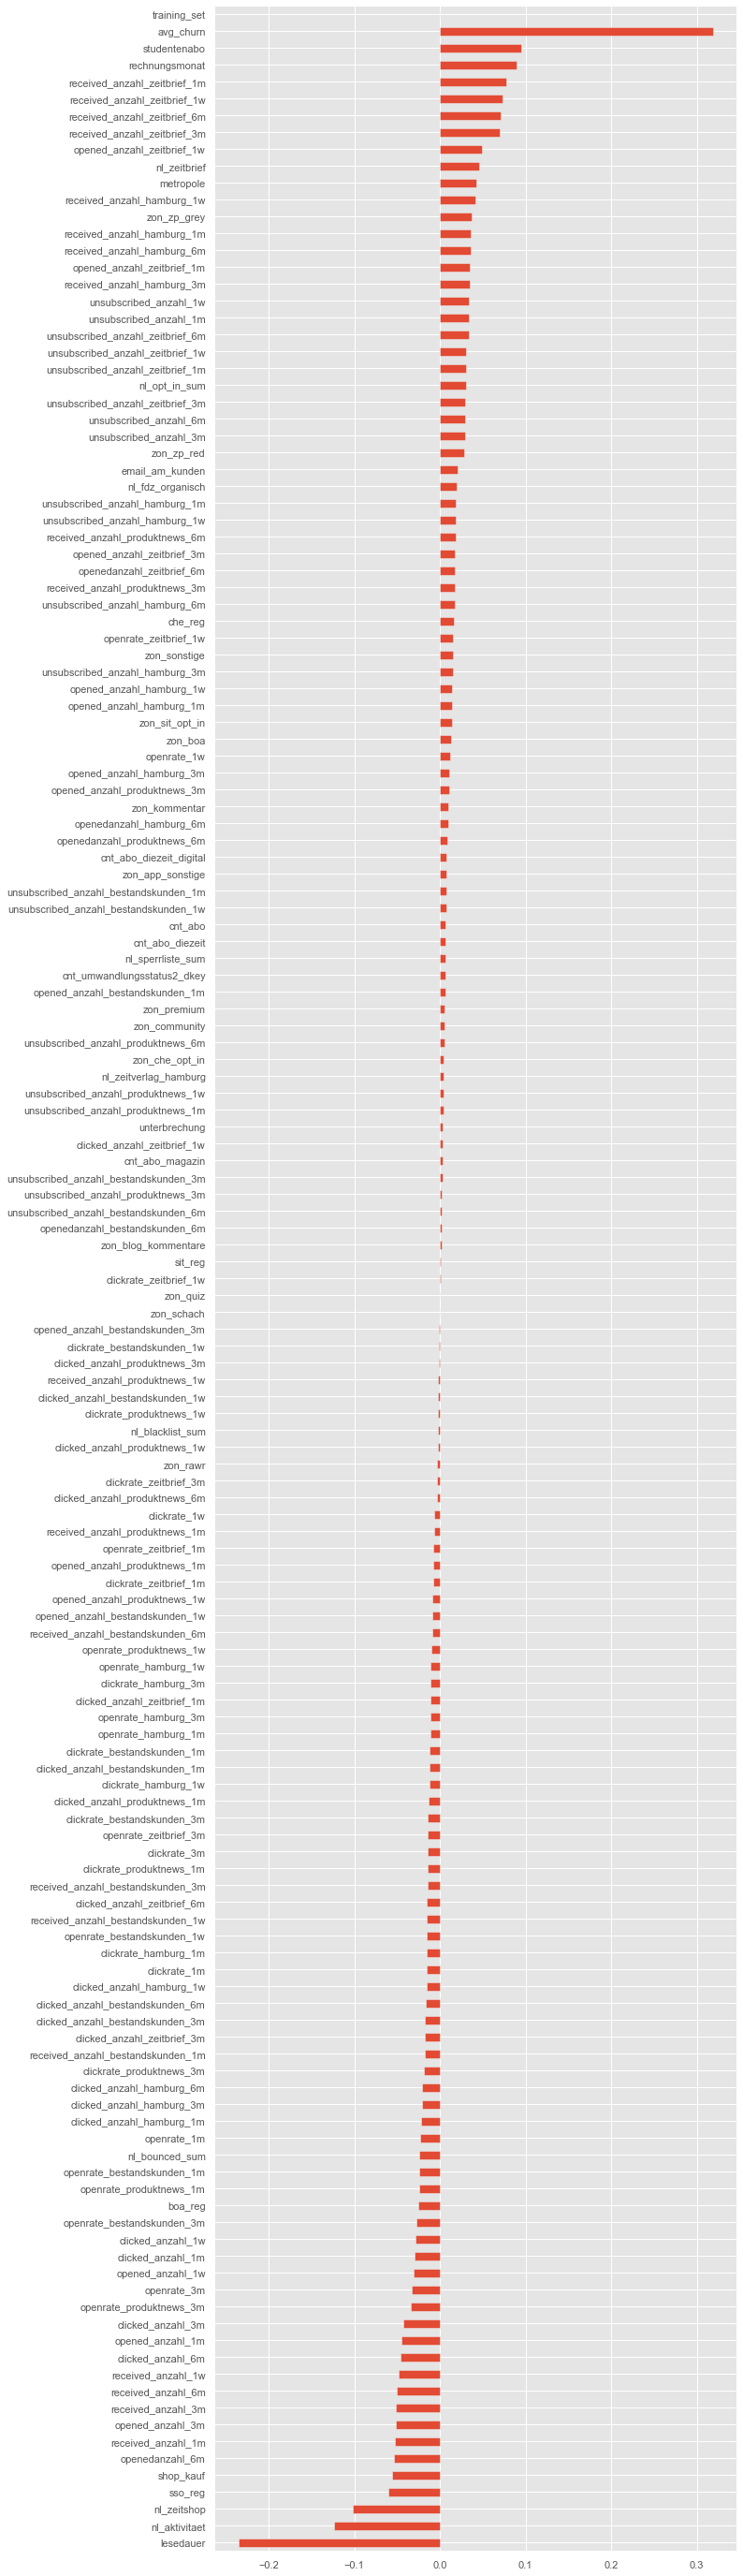

In [7]:
df.drop('churn', axis=1).corrwith(df.churn).sort_values().plot(kind='barh',figsize=(10, 50));

## Drop features

In [8]:
print(df.shape)
df.drop(["auftrag_new_id", "avg_churn", "ort", "date_x", "kuendigungs_eingangs_datum", "abo_registrierung_min", "training_set"], axis=1, inplace=True)
print(df.shape)

(209043, 170)
(209043, 163)


## Sample & split

In [9]:
# calculate sample size for 1% and 10%
one_percent = df.sample(int(round(len(df) / 100)))
ten_percent = df.sample(int(round(len(df) / 10)))
print(one_percent.shape)
print(ten_percent.shape)
ten_percent.head()

(2090, 163)
(20904, 163)


,liefer_beginn_evt,kanal,objekt_name,aboform_name,zahlung_rhythmus_name,lesedauer,rechnungsmonat,zahlung_weg_name,studentenabo,plz_1,...,unsubscribed_anzahl_zeitbrief_1m,unsubscribed_anzahl_zeitbrief_3m,unsubscribed_anzahl_zeitbrief_6m,openrate_zeitbrief_1w,clickrate_zeitbrief_1w,openrate_zeitbrief_1m,clickrate_zeitbrief_1m,openrate_zeitbrief_3m,clickrate_zeitbrief_3m,churn
22070,2014-05-22,andere,DIE ZEIT,Festabo,jährlich,64,0,Bankeinzug,1,1,...,0,0,0,1.0,0.0,0.8,0.0,0.69,0.0,1
82662,2017-04-27,Eigenwerbung,DIE ZEIT,Probeabo,jährlich,33,0,Bankeinzug,0,2,...,0,0,0,0.0,0.0,0.0,0.0,0.00,0.0,0
101446,2018-03-15,andere,DIE ZEIT,Probeabo,jährlich,26,0,Rechnung,0,6,...,0,0,0,0.0,0.0,0.0,0.0,0.00,0.0,1
40686,2013-02-07,andere,DIE ZEIT,Negative Option,jährlich,87,0,Rechnung,0,xx,...,0,0,0,0.0,0.0,0.0,0.0,0.00,0.0,0
56236,2017-07-06,andere,DIE ZEIT,Festabo,halbjährlich,25,0,Rechnung,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.00,0.0,0


In [10]:
y = ten_percent['churn']
X = ten_percent.drop('churn', axis = 1)
X.shape

(20904, 162)

## Pipeline

In [13]:
def pipeline(X,y):
    
    # devide features
    categoric_features = list(X.columns[X.dtypes==object])
    categoric_features

    numeric_features = list(X.columns[X.dtypes != object])
    numeric_features

    # split train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    # defining the models
    models = [
        LogisticRegression,
        KNeighborsClassifier,
        SVC,
        DecisionTreeClassifier,
        RandomForestClassifier, 
        XGBClassifier,
        AdaBoostClassifier
    ]

    # create preprocessors
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
            ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categoric_features)
        ])


    # process pipeline for every model
    for model in models:
        name = str(model).replace("'>", "").split(".")[-1]
        print(f"\n{name}")
        pipe = Pipeline(steps=[('preprocessor', preprocessor), 
                               ('classifier', model())
                               ])

        # fit model
        pipe.fit(X_train, y_train)  

        #predict results
        y_train_pred = cross_val_predict(pipe, X_train, y_train, cv=5)
        y_test_pred = pipe.predict(X_test)

        # print results
        # print("\nResults on training data: ")
        # print(classification_report(y_train, y_train_pred))
        print("\nResults on test data:")
        print(classification_report(y_test, y_test_pred))
        # print("\nConfusion matrix on test")
        # print(confusion_matrix(y_test, y_test_pred))
        # print("\n")

        # plot heatmap
        conf_mat = pd.crosstab(np.ravel(y_train), np.ravel(y_train_pred),
                               colnames=["Predicted"], rownames=["Actual"])
        sns.heatmap(conf_mat/np.sum(conf_mat), annot=True, cmap="Blues", fmt=".2%")
        plt.title('Confusion matrix for:\n{}'.format(name));
        # plt.savefig("plots/conf-matrix-train-{}.png.".format(name), dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
    
    # print balance and sizes
    print ("Testing set has {} features.".format(X_test.shape[1]))
    eda.plot_train_test_split(y,y_train,y_test)

# Results


LogisticRegression

Results on test data:
              precision    recall  f1-score   support

           0       0.76      0.87      0.81      3545
           1       0.61      0.44      0.51      1681

    accuracy                           0.73      5226
   macro avg       0.69      0.65      0.66      5226
weighted avg       0.72      0.73      0.72      5226



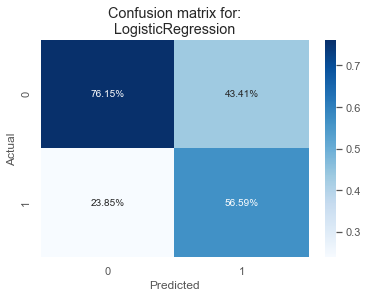


KNeighborsClassifier

Results on test data:
              precision    recall  f1-score   support

           0       0.73      0.83      0.78      3545
           1       0.50      0.36      0.42      1681

    accuracy                           0.68      5226
   macro avg       0.61      0.59      0.60      5226
weighted avg       0.66      0.68      0.66      5226



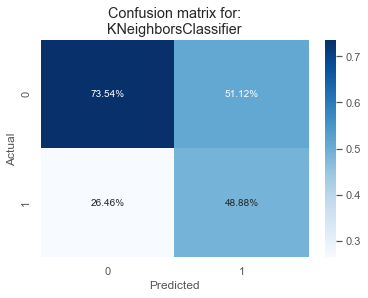


SVC

Results on test data:
              precision    recall  f1-score   support

           0       0.73      0.95      0.83      3545
           1       0.73      0.27      0.39      1681

    accuracy                           0.73      5226
   macro avg       0.73      0.61      0.61      5226
weighted avg       0.73      0.73      0.69      5226



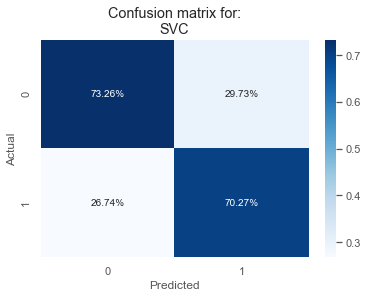


DecisionTreeClassifier

Results on test data:
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      3545
           1       0.52      0.46      0.49      1681

    accuracy                           0.69      5226
   macro avg       0.64      0.63      0.63      5226
weighted avg       0.68      0.69      0.68      5226



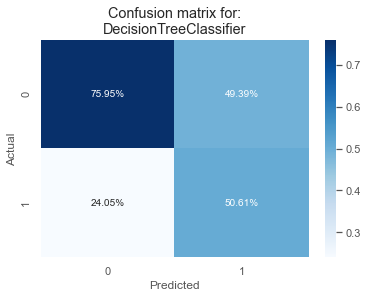


RandomForestClassifier

Results on test data:
              precision    recall  f1-score   support

           0       0.73      0.96      0.83      3545
           1       0.76      0.26      0.39      1681

    accuracy                           0.74      5226
   macro avg       0.75      0.61      0.61      5226
weighted avg       0.74      0.74      0.69      5226



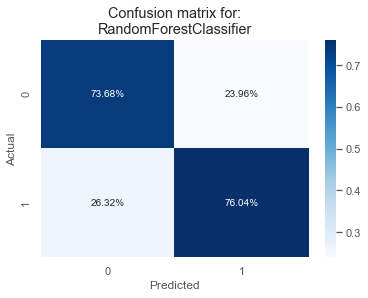


XGBClassifier

Results on test data:
              precision    recall  f1-score   support

           0       0.78      0.90      0.84      3545
           1       0.69      0.46      0.55      1681

    accuracy                           0.76      5226
   macro avg       0.73      0.68      0.69      5226
weighted avg       0.75      0.76      0.74      5226



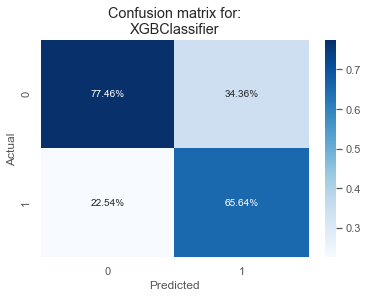


AdaBoostClassifier

Results on test data:
              precision    recall  f1-score   support

           0       0.76      0.90      0.82      3545
           1       0.64      0.39      0.48      1681

    accuracy                           0.73      5226
   macro avg       0.70      0.64      0.65      5226
weighted avg       0.72      0.73      0.71      5226



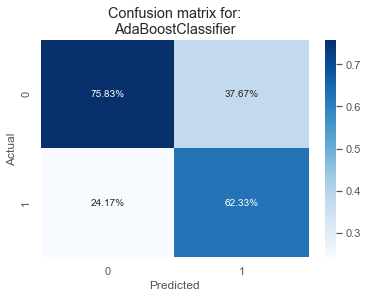

Testing set had 162 features.
Training set has 15678 samples.
Testing set has 5226 samples.


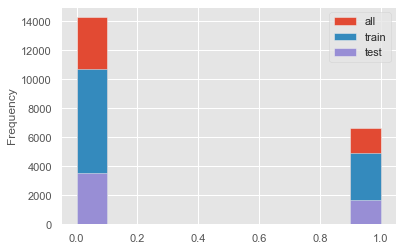

In [14]:
# 10 percent data
pipeline(X,y)